In [1]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

warnings.simplefilter(action='ignore', category=FutureWarning)

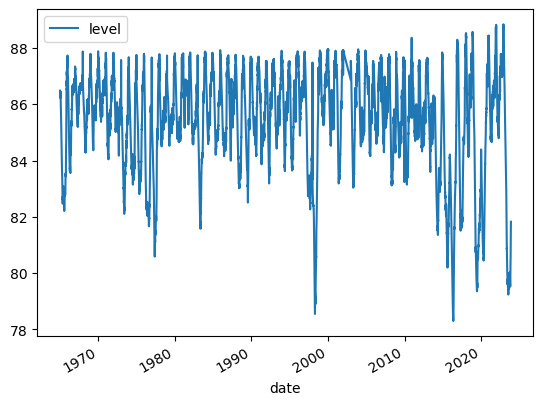

In [2]:
# Read Panama Canal historical data
historical = pd.read_csv('https://evtms-rpts.pancanal.com/eng/h2o/Download_Gatun_Lake_Water_Level_History.csv', 
                        parse_dates=['date'], index_col='date', na_values=['0'], 
                        names=['date', 'level'], skiprows=1)
historical = historical.dropna()
historical.plot();

In [3]:
enso = pd.read_html('https://iri.columbia.edu/our-expertise/climate/forecasts/enso/current/?enso_tab=enso-sst_table')
enso_forecast = enso[4]
enso_mean = enso_forecast.iloc[-1:]

enso_mean.columns = enso_mean.columns.droplevel(0)

# Rename columns NDJ as December, DFJ as January, etc.
enso_mean = enso_mean.copy()
# enso_mean.rename(columns={'NDJ': 'Dec', 'DJF': 'Jan', 'JFM': 'Feb', 'FMA': 'Mar', 'MAM': 'Apr', 'AMJ': 'May',
#                             'MJJ': 'Jun', 'JJA': 'Jul', 'JAS': 'Aug', 'ASO': 'Sep', 'SON': 'Oct', 'OND': 'Nov'},
#                 inplace=True)

enso_mean.rename(columns={'NDJ': 12, 'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5,
                            'MJJ': 6, 'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11},
                inplace=True)

# Reset and delete index
enso_mean.reset_index(inplace=True)
enso_mean.drop(columns=['index'], inplace=True)
enso_mean = enso_mean.T
enso_mean.columns = enso_mean.iloc[0]
enso_mean = enso_mean.iloc[1:]

# Rename Average, All models column to average
enso_mean.rename(columns={'Average, All models': 'average'}, inplace=True)

# Convert to average column to float
enso_mean['average'] = enso_mean['average'].astype(float)

enso_mean


Model,average
12,1.897
1,1.839
2,1.646
3,1.351
4,0.943
5,0.577
6,0.246
7,0.010
8,-0.137


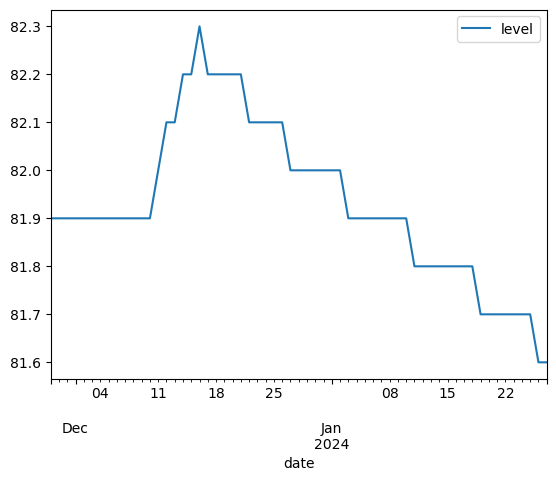

In [4]:
# Read Panama Canal forecast data
forecast = pd.read_csv('https://evtms-rpts.pancanal.com/eng/h2o/Gatun_Water_Level_Projection.csv', 
                        skiprows=3, parse_dates=['date'], index_col='date', usecols=['date', 'level'],
                        names=['date', 'level',])

forecast = forecast.sort_values(by='date')
forecast.plot();

In [5]:
# Read nino12_daily and nino34_daily data
nino34 = pd.read_csv('nino34_daily.csv', parse_dates=['date'], index_col='date', names=['date', 'nino34'],
                     skiprows=1)
nino12 = pd.read_csv('nino12_daily.csv', parse_dates=['date'], index_col='date', names=['date', 'nino12'],
                     skiprows=1)

# Merge nino12 and nino34 data
nino = pd.merge(nino12, nino34, left_index=True, right_index=True)

# Merge nino and historical data
df = pd.merge(historical, nino, left_index=True, right_index=True)
df

,level,nino12,nino34
date,,,
1981-09-01,86.67,0.07,-0.06
1981-09-02,86.65,0.13,-0.07
1981-09-03,86.67,0.21,-0.11
1981-09-04,86.55,-0.09,-0.30
1981-09-05,86.49,-0.35,-0.35
...,...,...,...
2023-11-18,81.26,1.82,2.05
2023-11-19,81.32,1.89,2.08
2023-11-20,81.34,1.85,2.13


In [6]:
# Add water level time lagging
def add_lags(df, n_days):
    df = df.copy()
    target_map = df['level'].to_dict()
    df[f'level_lag{n_days}'] = (df.index - pd.Timedelta(days=n_days)).map(target_map)
    return df

# Create time series features
def create_features(df):
    df = df.copy()
    df['dayofyear'] = df.index.dayofyear
    return df

water_level_lags = [7, 14, 30, 60, 120]

for n_days in water_level_lags:
    df = add_lags(df, n_days)

df = create_features(df)

# Drop rows with NaN values
df.dropna(inplace=True)

df.tail()


,level,nino12,nino34,level_lag7,level_lag14,level_lag30,level_lag60,level_lag120,dayofyear
date,,,,,,,,,
2023-11-18,81.26,1.82,2.05,80.49,80.35,79.64,79.83,79.35,322
2023-11-19,81.32,1.89,2.08,80.70,80.35,79.62,79.89,79.36,323
2023-11-20,81.34,1.85,2.13,80.71,80.44,79.63,79.93,79.32,324
2023-11-21,81.48,1.95,2.15,80.69,80.44,79.65,79.93,79.28,325
2023-11-22,81.63,2.10,2.19,80.74,80.47,79.62,79.90,79.24,326


In [7]:
# from sklearn.model_selection import TimeSeriesSplit

# tss = TimeSeriesSplit(n_splits=5, test_size=365 * 5, gap=1)

# fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

# fold = 0 
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train['level'].plot(ax=axs[fold], label='train', title=f'Train/Test Split - Fold {fold}')
#     test['level'].plot(ax=axs[fold], label='test', title=f'Train/Test Split - Fold {fold}')
#     axs[fold].axvline(test.index.min(), color='black', linestyle='--')

#     fold += 1
# plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
preds = []
scores = []

tss = TimeSeriesSplit(n_splits=5, test_size=365 * 5, gap=1)

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['level_lag7', 'level_lag14', 'level_lag30', 'level_lag60', 'level_lag120',
                'dayofyear', 'nino12', 'nino34']
    TARGET = 'level'

    X_train = train[FEATURES]
    Y_train = train[TARGET]

    X_test = test[FEATURES]
    Y_test = test[TARGET]

    reg = xgb.XGBRegressor(n_estimators=1000, base_score=0.5, booster='gbtree', early_stopping_rounds=50,
                           objective='reg:squarederror', random_state=42, learning_rate=0.01, max_depth=3,)
    
    reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(Y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:84.44928	validation_1-rmse:83.95042


[100]	validation_0-rmse:30.92795	validation_1-rmse:30.53181
[200]	validation_0-rmse:11.33127	validation_1-rmse:11.10381
[300]	validation_0-rmse:4.15727	validation_1-rmse:4.05242
[400]	validation_0-rmse:1.53651	validation_1-rmse:1.53937
[500]	validation_0-rmse:0.59423	validation_1-rmse:0.76882
[600]	validation_0-rmse:0.28403	validation_1-rmse:0.63788
[672]	validation_0-rmse:0.21666	validation_1-rmse:0.63823
[0]	validation_0-rmse:84.32888	validation_1-rmse:84.55478
[100]	validation_0-rmse:30.88349	validation_1-rmse:31.00085
[200]	validation_0-rmse:11.31447	validation_1-rmse:11.36196
[300]	validation_0-rmse:4.15137	validation_1-rmse:4.16849
[400]	validation_0-rmse:1.53571	validation_1-rmse:1.54437
[500]	validation_0-rmse:0.59778	validation_1-rmse:0.61833
[600]	validation_0-rmse:0.29203	validation_1-rmse:0.33847
[700]	validation_0-rmse:0.21558	validation_1-rmse:0.28022
[800]	validation_0-rmse:0.20019	validation_1-rmse:0.27105
[900]	validation_0-rmse:0.19496	validation_1-rmse:0.27008
[948]	

In [9]:
scores

[0.6345394311562373,
 0.2700624495268208,
 0.35915855545203185,
 0.3271802493562415,
 0.3108437504467926]

In [10]:
# Retrain on full data
df = create_features(df)

FEATURES = ['level_lag7', 'level_lag14', 'level_lag30', 'level_lag60', 'level_lag120',
            'dayofyear', 'nino12', 'nino34']
TARGET = 'level'

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(n_estimators=800, max_depth=5, learning_rate=0.05, 
                         random_state=42, objective='reg:squarederror')

model.fit(X_all, y_all,
          eval_set=[(X_all, y_all)],
          verbose=100)                         

[0]	validation_0-rmse:80.62717
[100]	validation_0-rmse:0.53153
[200]	validation_0-rmse:0.19775
[300]	validation_0-rmse:0.17955
[400]	validation_0-rmse:0.16820
[500]	validation_0-rmse:0.15664
[600]	validation_0-rmse:0.14768
[700]	validation_0-rmse:0.13774
[799]	validation_0-rmse:0.12960


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

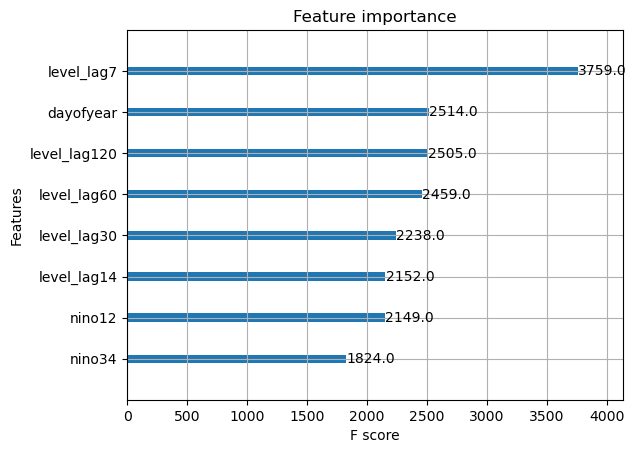

In [11]:
# Plot feature importances
xgb.plot_importance(model)
plt.show()

In [20]:
future = pd.date_range('2023-11-23', '2023-11-29', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

# Create features for future data
df_and_future = create_features(df_and_future)

df_and_future

,level,nino12,nino34,level_lag7,level_lag14,level_lag30,level_lag60,level_lag120,dayofyear,isFuture
1981-12-30,87.64,0.21,-0.18,87.70,87.69,87.58,85.85,86.67,364,False
1981-12-31,87.67,-0.01,0.01,87.38,87.76,87.56,85.85,86.65,365,False
1982-01-01,87.72,-0.39,0.15,87.36,87.79,87.46,85.85,86.67,1,False
1982-01-02,87.85,-0.67,0.34,87.60,87.74,87.44,85.92,86.55,2,False
1982-01-03,87.75,-0.61,0.42,87.57,87.77,87.43,86.07,86.49,3,False
...,...,...,...,...,...,...,...,...,...,...
2023-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329,True
2023-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330,True
2023-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331,True
2023-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332,True


In [21]:
# Add time lagging for future data
for n_days in water_level_lags:
    df_and_future = add_lags(df_and_future, n_days)

# Copy nino12 and nino34 data to the first row of future data
df_and_future['nino12'] = df_and_future['nino12'].shift(1)
df_and_future['nino34'] = df_and_future['nino34'].shift(1)

df_and_future.loc['2023-11-22']

level           81.63
nino12           1.95
nino34           2.15
level_lag7      80.74
level_lag14     80.47
level_lag30     79.62
level_lag60      79.9
level_lag120    79.24
dayofyear         326
isFuture        False
Name: 2023-11-22 00:00:00, dtype: object

In [27]:
future_w_features = df_and_future.query('isFuture == True').copy()

# Add nino12 and nino34 forecast data from enso_mean (IRI dataset) for months where we have forecast data
for i in range(1, 13):
    if i not in enso_mean.index:
        continue
    future_w_features.loc[future_w_features.index.month == i, 'nino12'] = enso_mean.loc[i, 'average']
    future_w_features.loc[future_w_features.index.month == i, 'nino34'] = enso_mean.loc[i, 'average']

# Copy nino12 and nino34 from the first row to the next rows until a non-NaN value is found
# The first non-NaN value will be the first forecasted value from IRI
future_w_features['nino12'] = future_w_features['nino12'].fillna(method='ffill')
future_w_features['nino34'] = future_w_features['nino34'].fillna(method='ffill')

In [30]:
# Make predictions for future data. As predictions are made for each row, calculate the lagged values for the next row
# and use that for the next prediction

future_w_features['level'] = model.predict(future_w_features[FEATURES])
future_w_features

,level,nino12,nino34,level_lag7,level_lag14,level_lag30,level_lag60,level_lag120,dayofyear,isFuture
2023-11-23,79.566177,2.1,2.19,NaN,80.49,79.57,79.94,79.25,327,True
2023-11-24,79.494331,2.1,2.19,NaN,80.49,79.53,80.02,79.25,328,True
2023-11-25,79.494331,2.1,2.19,NaN,80.49,79.58,80.01,79.27,329,True
2023-11-26,79.326042,2.1,2.19,NaN,80.70,79.63,79.99,79.42,330,True
2023-11-27,79.321220,2.1,2.19,NaN,80.71,79.70,79.99,79.67,331,True
2023-11-28,79.321220,2.1,2.19,NaN,80.69,79.72,79.99,79.80,332,True
2023-11-29,79.318504,2.1,2.19,NaN,80.74,79.70,79.97,79.77,333,True


In [31]:
# Take level predictions and use them as lagged values for the next row
new = future_w_features['level_lag7'] = future_w_features['level'].shift(7)

new

2023-11-23   NaN
2023-11-24   NaN
2023-11-25   NaN
2023-11-26   NaN
2023-11-27   NaN
2023-11-28   NaN
2023-11-29   NaN
Name: level, dtype: float32

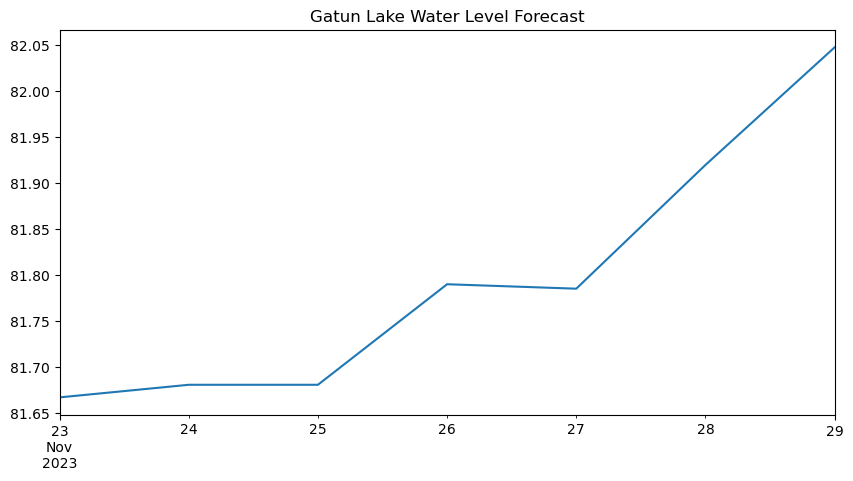

In [24]:
future_w_features['level'].plot(figsize=(10, 5), title='Gatun Lake Water Level Forecast');

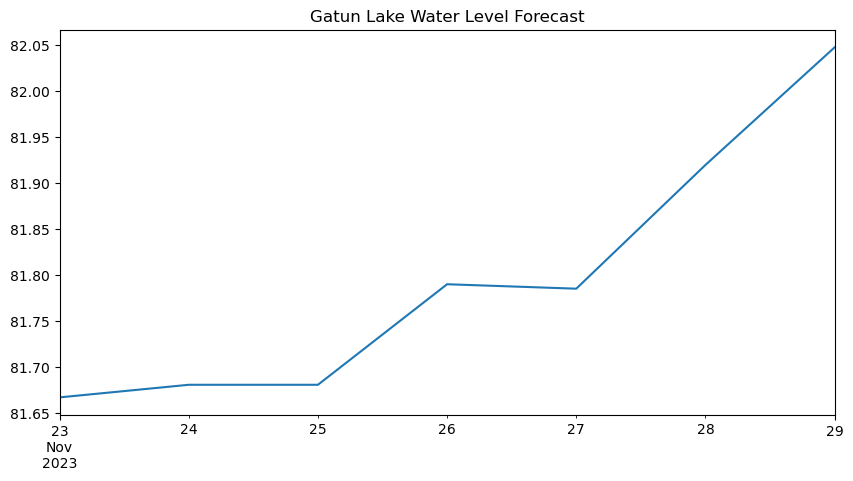

In [26]:
future_w_features['level'].plot(figsize=(10, 5), title='Gatun Lake Water Level Forecast');